<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Headless_ecommerce_chat_with_fashion_products_using_langchain_and_pinecone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install protobuf==3.20.3

In [2]:
!pip install -qU langchain openai transformers sentence-transformers datasets pinecone-client pinecone-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00

## Hybrid Search

Hybrid vector search is **combination of traditional keyword search and modern dense vector search**. It has emerged as a powerful tool for e-commerce companies looking to improve the search experience for their customers.

By combining the strengths of traditional text-based search algorithms with the visual recognition capabilities of deep learning models, hybrid vector search allows users to search for products using a combination of text and images. This can be especially useful for product searches, where customers may not know the exact name or details of the item they are looking for.

Pinecone's **sparse-dense** index allows to seamlessly perform hybrid search for e-commerce or in any other context.

## Connect to Pinecone
* Let's initiate a connection and create an index.
* For this, we need a free API key, and then we initialize the connection like so:

In [3]:
import os
import pinecone
from getpass import getpass
from tqdm.autonotebook import tqdm
#
os.environ["PINECONE_API_KEY"] = getpass("Enter the api key here... ")
os.environ["PINECONE_ENVIRONMENT"] = getpass("Enter the pinecone environment here ... ")

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or "PINECONE_API_KEY"
# find your environment next to the api key in pinecone console
env = os.getenv("PINECONE_ENVIRONMENT") or "PINECONE_ENVIRONMENT"

# init connection to pinecone
pinecone.init(
    api_key=api_key,
    environment=env
)

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Enter the api key here... ··········
Enter the pinecone environment here ... ··········


## Create pinecone index

In [4]:
# choose a name for your index
index_name = "hybrid-image-search"

if index_name not in pinecone.list_indexes():
    # create the index
    pinecone.create_index(
      index_name,
      dimension=512,
      metric="dotproduct",
      pod_type="s1"
    )

## Connect to pinecone

In [5]:
index = pinecone.Index(index_name)

## Load Dataset
We will work with a subset of the Open Fashion Product Images dataset, consisting of ~44K fashion products with images and category labels describing the products. The dataset can be loaded from the Huggigface Datasets hub as follows:

In [6]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [7]:
images = fashion["image"]
data = fashion.remove_columns("image")
product_df = data.to_pandas()
product_data = product_df.reset_index(drop=True).to_dict(orient="index")
print(product_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
product_data[0]

{'id': 15970,
 'gender': 'Men',
 'masterCategory': 'Apparel',
 'subCategory': 'Topwear',
 'articleType': 'Shirts',
 'baseColour': 'Navy Blue',
 'season': 'Fall',
 'year': 2011.0,
 'usage': 'Casual',
 'productDisplayName': 'Turtle Check Men Navy Blue Shirt'}

In [9]:
product_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


* We need both sparse and dense vectors to perform hybrid search.
* We will use all the fields from product dataframe except for the **id** and **year** to create **sparse vectors** and the **product images** to create **dense vectors.**

## Sparse Vectors
To create the sparse vectors we'll use BM25. We import the BM25 function from the pinecone-text library.

In [10]:
from pinecone_text.sparse import BM25Encoder
#
bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
bm25.fit(product_df['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

In [ ]:
product_df['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

##checking the vector representation
*  productdisplay name: Turtle Check Men Navy Blue Shirt

In [ ]:
bm25.encode_queries(product_df['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

*  for the stored docs, we only need the "IDF" part:

In [ ]:
bm25.encode_documents(product_df['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Dense Vectors
We will use the CLIP to generate dense vectors for product images. We can directly pass PIL images to CLIP as it can encode both images and texts. We can load CLIP like so:

In [11]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device : {device}")
# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

device : cpu


SentenceTransformer(
  (0): CLIPModel()
)

In [ ]:
dense_vec = model.encode([product_df['productDisplayName'][0]])
dense_vec.shape

(1, 512)

* he model gives us a 512 dimensional dense vector.

## Upsert Documents
Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [ ]:
from tqdm.auto import tqdm
metadata = product_df.copy()
batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

  0%|          | 0/221 [00:00<?, ?it/s]

In [12]:
# show index description after uploading the documents
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

## Create documents

In [ ]:
product_df[product_df['id'] == 9168]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
11868,9168,Men,Apparel,Bottomwear,Jeans,Blue,Fall,2011.0,Casual,Locomotive Men Radley Blue Jeans


In [13]:
from langchain.document_loaders.base import Document
def create_docs(results):
  docs = []
  for i,result in enumerate(results['matches']):
    #print(result)
    pid = int(result['metadata']['id'])
    #print(pid)
    score = result['score']
    #print(score)
    result_string = ""
    #
    product_name = product_df[product_df['id'] == pid][['productDisplayName']].values[0].tolist()[0]
    category = product_df[product_df['id'] == pid][["masterCategory"]].values[0].tolist()[0]
    article = product_df[product_df['id'] == pid][["articleType"]].values[0].tolist()[0]
    usage = product_df[product_df['id'] == pid][["usage"]].values[0].tolist()[0]
    season = product_df[product_df['id'] == pid][["season"]].values[0].tolist()[0]
    gender = product_df[product_df['id'] == pid][["gender"]].values[0].tolist()[0]
    #
    result_string += "Product Name:" +product_name+";" + "Category:" +category+";" + "Article Type:"+article+";"\
    "Usage:" + usage + ";" + "Season:" + season+ ";"+ "Gender:" + gender
    #
    doc = Document(page_content = result_string)
    doc.metadata['pid'] = str(pid)
    doc.metadata['score'] = score
    docs.append(doc)
  return docs

## Helper function to display image

In [14]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

## Helper function to print image details

In [15]:
def print_images(results):
  for result in results:
    pid = result['id']
    print(product_df[pid]['productDisplayName'])
    display(images[pid])

## Hybrid Scale embedding

In [16]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

## Generative Question-Answering

In [18]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

In [19]:
os.environ["OPENAI_API_KEY"] = getpass()

··········


In [20]:
# completion llm
llm = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model_name='gpt-3.5-turbo',
    temperature=0.0
)

## Vectorstore


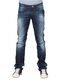
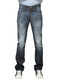
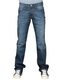
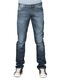
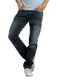
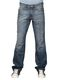
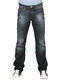
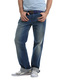
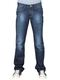
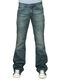
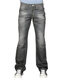
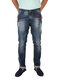
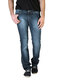
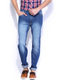

In [23]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

## Using Scaled hybrid search


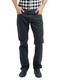
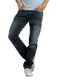
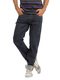
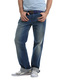
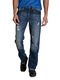
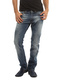
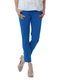
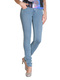
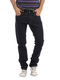
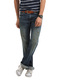
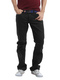
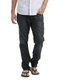
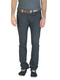
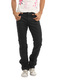

In [28]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)


## Hybrid Search : giving equal importance to sparse and dense serach==> alpha =0.5


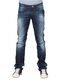
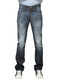
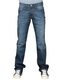
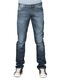
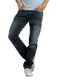
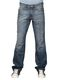
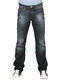
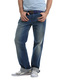
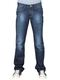
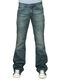
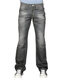
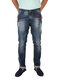
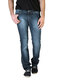
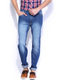

In [29]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)


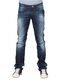
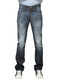
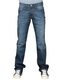
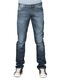
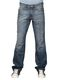
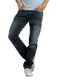
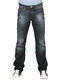
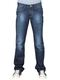
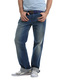
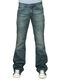
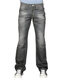
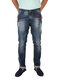
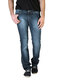
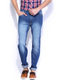

In [30]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.8)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [24]:
len(result['matches'])

14

In [31]:
result['matches'][0]

{'id': '11868',
 'metadata': {'articleType': 'Jeans',
              'baseColour': 'Blue',
              'gender': 'Men',
              'id': 9168.0,
              'masterCategory': 'Apparel',
              'productDisplayName': 'Locomotive Men Radley Blue Jeans',
              'season': 'Fall',
              'subCategory': 'Bottomwear',
              'usage': 'Casual',
              'year': 2011.0},
 'score': 25.0585518,
 'values': []}

In [26]:
docs = create_docs(result)

In [27]:
docs

[Document(page_content='Product Name:Locomotive Men Radley Blue Jeans;Category:Apparel;Article Type:Jeans;Usage:Casual;Season:Fall;Gender:Men', metadata={'pid': '9168', 'score': 31.4367447}),
 Document(page_content='Product Name:Locomotive Men Race Blue Jeans;Category:Apparel;Article Type:Jeans;Usage:Casual;Season:Fall;Gender:Men', metadata={'pid': '9167', 'score': 30.8277035}),
 Document(page_content='Product Name:Locomotive Men Eero Blue Jeans;Category:Apparel;Article Type:Jeans;Usage:Casual;Season:Fall;Gender:Men', metadata={'pid': '9178', 'score': 30.6588669}),
 Document(page_content='Product Name:Locomotive Men Cam Blue Jeans;Category:Apparel;Article Type:Jeans;Usage:Casual;Season:Fall;Gender:Men', metadata={'pid': '9164', 'score': 30.4708481}),
 Document(page_content='Product Name:French Connection Men Blue Jeans;Category:Apparel;Article Type:Jeans;Usage:Casual;Season:Summer;Gender:Men', metadata={'pid': '48398', 'score': 30.4667873}),
 Document(page_content='Product Name:Locomot

## Feed results to a large language model

In [32]:
template = """
You are a fashion shopping assistant aiming to persuade customers using the provided information. Describe the season and usage mentioned in the context in your interaction with the customer.
Utilize a bullet list to detail each product for the customer.

Context : {context}
User question :{question}
Your Response:"""
#
prompt = PromptTemplate.from_template(template)


In [33]:
prompt

PromptTemplate(input_variables=['context', 'question'], output_parser=None, partial_variables={}, template='\nYou are a fashion shopping assistant aiming to persuade customers using the provided information. Describe the season and usage mentioned in the context in your interaction with the customer. \nUtilize a bullet list to detail each product for the customer.\n\nContext : {context}\nUser question :{question}\nYour Response:', template_format='f-string', validate_template=True)

In [34]:
chain = load_qa_chain(llm=ChatOpenAI(model_name="gpt-4",
                                     temperature=0.2),
                      chain_type='stuff',
                      prompt=prompt)

In [35]:
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)

In [38]:
result = response['output_text']
print(result)

Sure, I can help you with that. The French Connection Men Blue Jeans are a perfect choice for casual wear. They are particularly suitable for the summer season. Here are the details:

- Product Name: French Connection Men Blue Jeans
- Category: Apparel
- Article Type: Jeans
- Usage: Casual
- Season: Summer
- Gender: Men

These jeans are stylish and comfortable, making them a great addition to your summer wardrobe.



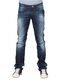
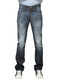
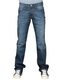
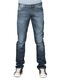
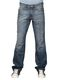
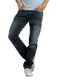
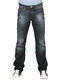
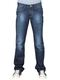
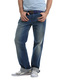
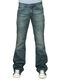
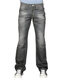
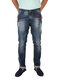
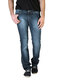
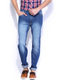

In [39]:
# display the images
display_result(imgs)

## Example 2: Searching based on textual description

Sure, here are some pink tops that you might be interested in:

- Doodle Kids Girl Striped Pink Top: This is a casual top perfect for the summer season. It's designed for girls.
- Remanika Women Pink Top: This is a casual women's top that is great for the summer season.
- PUMA Women Pink Top: This is a casual top designed for women. It's suitable for the winter season.
- Gini and Jony Girls Pink Top: This is a casual top designed for girls. It's perfect for the summer season.
- Palm Tree Girls Pink Top: This is a casual top designed for girls. It's suitable for the summer season. 

Please let me know if you need more information about any of these tops.



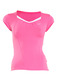
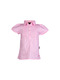
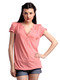
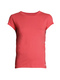
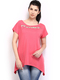
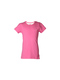
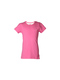
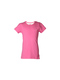
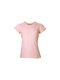
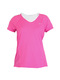
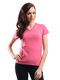
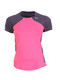
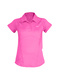
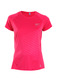

In [41]:
question = "pink colour top"
# create the sparse vector
sparse = bm25.encode_queries(question)
dense = model.encode(question).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
#Generate the documents for the LLM to interact with
docs = create_docs(result)
#Feed the documents to the large language model
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
# print response
results = response['output_text']
print(results)
# Display images
display_result(imgs)


## Example 3 :

#### Use a product image to create our dense vector,
* The user  provides a text query that will be used to create the sparse vector,
* the user provided image will be used for dense embedding
* and then we'll select a specific color as per the metadata attached to each image, with metadata filtering.

#### Image provided

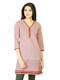

In [42]:
images[36254]

#### Textual description provided

I understand you're looking for purple tops. Here are some options that you might like:

- Mother Earth Women Beige Printed Kurta: This is a beautiful beige kurta with a unique print. It's perfect for the fall season and can be worn for ethnic occasions.
- Folklore Women Red Printed Kurta: This is a vibrant red kurta with a stylish print. It's also suitable for the fall season and ethnic events.
- Mother Earth Women Orange Kurta: This is a bright orange kurta that's perfect for fall. It's an excellent choice for ethnic wear.
- W Women Printed Purple Kurtas: This is a stunning purple kurta with a stylish print. It's suitable for both the fall and summer seasons, making it a versatile addition to your wardrobe.
  
Please note that all these kurtas are designed for women and fall under the apparel category.



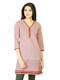
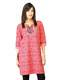
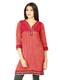
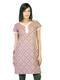
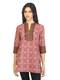
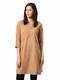
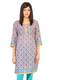
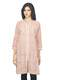
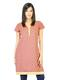
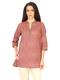
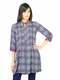
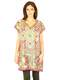
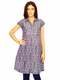
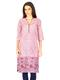

In [43]:
question = "purple tops"
# create the sparse vector
sparse = bm25.encode_queries(question)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
#Generate the documents for the LLM to interact with
docs = create_docs(result)
#Feed the documents to the large language model
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
# print response
results = response['output_text']
print(results)
# Display images
display_result(imgs)

#### Our "purple" component isn't being considered strongly enough, let's add this to the metadata filtering:

Sure, I can help you with that. Here are some beautiful purple kurtas that are perfect for ethnic occasions. They are suitable for both fall and summer seasons. 

- W Women Printed Purple Kurtas: This is a beautiful ethnic wear that you can wear during the fall season.
- W Women Printed Purple Kurtas: This is another variant of the same kurta that is perfect for the summer season.
- Aneri Women Cleo Purple Kurta: This is a stylish kurta that you can wear during the fall season.
- W Women Purple Kurta: This is a simple yet elegant kurta that is perfect for the fall season.
- W Women Printed Purple Kurtas: This is another beautiful printed kurta that you can wear during the summer season.
- W Women Printed Purple Kurtas: This is a beautiful printed kurta that is perfect for the fall season.
- W Women Block Print Purple Kurta: This is a block printed kurta that is perfect for the fall season.
- Fabindia Women Purple Printed Silk Kurta: This is a silk kurta with beautiful prints that is pe


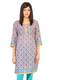
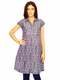
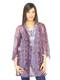
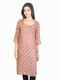
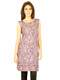
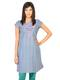
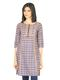
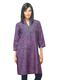
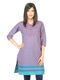
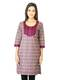
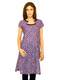
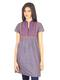
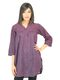
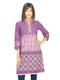

In [44]:
question = "purple tops"
# create the sparse vector
sparse = bm25.encode_queries(question)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
#Generate the documents for the LLM to interact with
docs = create_docs(result)
#Feed the documents to the large language model
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
# print response
results = response['output_text']
print(results)
# Display images
display_result(imgs)

* here we have not mentioned male / female  topwears only the image has been share, and the resluts presented were for female top wear

## Example 3: Search with another image

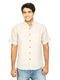

In [45]:
images[36256]

In [48]:
question = "soft green color shirt"

I'm sorry, but we currently don't have any soft green color shirts available. However, we do have a wide range of purple shirts that are perfect for casual wear. They are suitable for both summer and fall seasons. Here are some options:

- United Colors of Benetton Women Purple Shirt: A casual summer shirt for women.
- United Colors of Benetton Men Check Purple Shirts: A casual summer shirt for men with a check pattern.
- United Colors of Benetton Women Purple Printed Shirt: A casual summer shirt for women with a unique print.
- United Colors of Benetton Men Check Purple Shirt: Another casual summer shirt for men with a check pattern.
- United Colors of Benetton Men Purple Check Shirt: A casual shirt for men, perfect for the fall season.
- United Colors of Benetton Women Solid Purple Shirt: A solid purple shirt for women, suitable for summer.
- United Colors of Benetton Men Checks Purple Shirts: A fall season shirt for men with checks.
- United Colors of Benetton Men Solid Purple Shirt


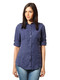
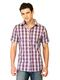
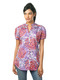
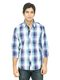
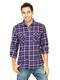
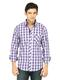
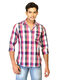
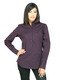
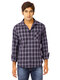
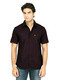
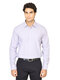
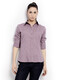
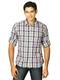
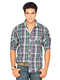

In [50]:
# create the sparse vector
sparse = bm25.encode_queries(question)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
#Generate the documents for the LLM to interact with
docs = create_docs(result)
#Feed the documents to the large language model
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
# print response
results = response['output_text']
print(results)
# Display images
display_result(imgs)

#### Include metada data filtering for exact colour product serach

Absolutely, I can help you with that. Here are some soft green color shirts that are perfect for casual wear during the summer and fall seasons:

- Scullers Men Striped Green Shirt: This casual shirt is perfect for summer. It features a striped pattern that adds a touch of sophistication to your casual look.
- Wrangler Men Green Shirt: This is another great option for summer. It's a casual shirt that will keep you comfortable during the hot season.
- Basics Men Green Checked Shirt: This shirt is also designed for summer use. The checked pattern gives it a stylish and casual look.
- John Players Men Bright Striped Shirt: This shirt is perfect for summer. The bright stripes add a pop of color to your outfit.
- United Colors of Benetton Men Solid Green Shirts: This solid green shirt is a great choice for summer. It's casual and comfortable, perfect for everyday wear.
- Wills Lifestyle Men Check Green Shirt: This checked green shirt is designed for summer. It's casual and stylish, perfect 


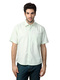
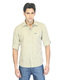
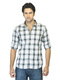
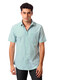
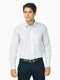
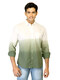
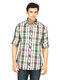
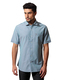
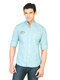
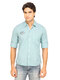
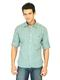
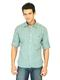
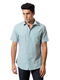
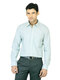

In [52]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
#Generate the documents for the LLM to interact with
docs = create_docs(result)
#Feed the documents to the large language model
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
# print response
results = response['output_text']
print(results)
# Display images
display_result(imgs)

##Example 4 : Search for kids shoes

Absolutely, I have a variety of kids' shoes suitable for different seasons and casual usage. Here are some options:

Winter Season:
- Warner Bros Kids Unisex SD Silly Shoe Blue Casual Shoes: These are unisex shoes, perfect for casual wear.
- Marvel Boys Blue Shoes: These are casual shoes specifically for boys.
- Disney Kids Red Casual Shoes: These are casual shoes designed for girls.
- Disney Kids-Unisex White Shoes: These are unisex casual shoes.

Fall Season:
- Warner Bros Kids Unisex SD Silly Shoe Silver Casual Shoes: These are unisex shoes, suitable for casual wear.
- Warner Bros Kids Unisex LT Blug Clog Green Sandals: These are unisex sandals for casual use.
- Marvel Boys Yellow and Orange Slippers: These are flip flops designed for boys.
- Jungle Book Boys Green Slippers: These are flip flops designed for boys.

Spring Season:
- Warner Bros Kids Girls TW Rainbow Clog Pink Sandals: These are sandals designed for girls.
- Warner Bros Kids Unisex SD Fire Canvas Navy Blue Casual Shoe


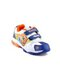
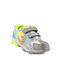
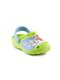
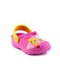
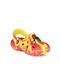
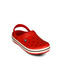
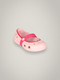
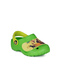
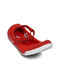
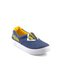
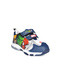
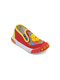
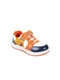
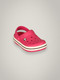

In [55]:
question = "kids shoes"
# create the sparse vector
sparse = bm25.encode_queries(question)
# now create the dense vector using the image
dense = model.encode(question).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
#Generate the documents for the LLM to interact with
docs = create_docs(result)
#Feed the documents to the large language model
response = chain({"input_documents":docs,
                  "question":question},
                 return_only_outputs=True)
# print response
results = response['output_text']
print(results)
# Display images
display_result(imgs)